For BUQEYE reviewers: 
* `#xxx` marks places where there are comment lines that might be deleted. Please check (and delete if you know they can be removed).
* `#???` marks questions to be resolved.

# Derivatives with Gaussian Processes

Tests and demonstrations of derivatives with Gaussian processes (GPs) plus figures from two papers.

Figures in the main text and supplementary material for _How well do we know the neutron-matter equation of state at the densities inside neutron stars? A Bayesian approach with correlated uncertainties_ by [BUQEYE](https://buqeye.github.io/) members Christian Drischler, Jordan Melendez, Dick Furnstahl, and Daniel Phillips (see [[arXiv:2004.07232]](https://arxiv.org/abs/2004.07232)). Generated for _Quantifying uncertainties and correlations in the nuclear-matter equation of state_ by the same authors (see [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805)) are figures 13 and 14 showing order-by-order predictions of the pressure and compressibility of symmetric nuclear matter (SNM) for $\Lambda = 500\,$MeV interactions.
The results and figures here can be easily modified and extended.

This notebook uses modules from standard Python packages, the corner package, gptools, and the local nuclear_matter package (**Add installation instructions**). 


#### Table of contents

1. [Defaults for figures](#figure_defaults)
1. [Standard case](#standard_case)
  1. [Fitting a function f(x)](#fitting_function)
  1. [Estimating the derivative f'(x)](#estimating_derivative)
1. [Nuclear matter application](#nuclear_matter)
  1. [Import the data](#import_data) 
  1. [Order-by-order predictions with uncertainties](#order_by_order)
  1. [Speed of sound in neutron matter](#sound_speed)


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Standard Python modules
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import matplotlib.patches as mpatches
import pandas as pd
import time

import corner  # https://corner.readthedocs.io/en/latest/

# To use gptools with Python 3, clone from GitHub repository 
#   https://github.com/markchil/gptools (development version)
# and install with 'pip install .' from inside repo. 
import gptools   # https://gptools.readthedocs.io/en/latest/

from nuclear_matter import fermi_momentum, nuclear_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov
from nuclear_matter.graphs import add_top_order_legend, compute_filled_handles, plot_empirical_saturation

## Set up the defaults for figures <a id="figure_defaults"></a>

The appearance of figures can be adjusted by changing `setup_rc_params` in `nuclear_matter` or by overriding those choices here. 

In [2]:
#xxx Do we need these commented lines?
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['figure.dpi'] = 130
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['ytick.direction'] = 'in'
# mpl.rcParams['xtick.direction'] = 'in'
# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')
setup_rc_params()

In [3]:
COLOR_68 = 'darkgrey'   # color for 1 sigma bands
COLOR_95 = 'lightgrey'  # color for 2 sigma bands

def curve_plus_bands_plot(ax, x, y, std, color_68=None, color_95=None, 
                          zorder=None, edgecolor=None, **kwargs):
    """
    Plot y vs. x with one sigma and two sigma bands based on std on axis ax.
     Add any other keyword pairs to style the main curve.
    """
#     if color_68 is None:
#         color_68 = COLOR_68
#     if color_95 is None:
#         color_95 = COLOR_95
    ax.plot(x, y, zorder=zorder, **kwargs)
    if color_95 is not None:
        ax.fill_between(x, y + 2*std, y - 2*std, facecolor=color_95, 
                        edgecolor=edgecolor, zorder=zorder)
    if color_68 is not None:
        ax.fill_between(x, y + std, y - std, facecolor=color_68, 
                        edgecolor=edgecolor, zorder=zorder)
    return ax


## Standard Case <a id="standard_case"></a>

We have data and would like to find a function that best captures the relationship between the inputs and outputs.
A popular nonparametric tool for regression is a Gaussian process (GP).
One of the neat things about a GP is that you automatically get uncertainty quantification along with the line of best fit.
But what is less well known is that it also provides derivatives of the best fit line, and corresponding uncertainty estimates, for free!

The derivative is a linear operator, so the distributions for derivatives follow similarly to how one transforms a Gaussian random variable by scalars or matrices.
Suppose $f$ is distributed as a ($n$-dimensional, for genalizability) Gaussian random variable,
\begin{align}
    f \sim N(0, \Sigma).
\end{align}
Then for some $N\times n$ matrix $C = [1, D]^T$,
\begin{align}
    C f = \begin{bmatrix} 1 \\ D \end{bmatrix} f
    \sim N(0, C \Sigma C^T)
\end{align}
Suppose now that $D = d/dx$ and $f$ is some function of $x$, distributed as a Gaussian process:
\begin{align}
    f(x) \sim GP[0, \kappa(x, x')].
\end{align}
The above logic allows us to find how $f$ correlates with its derivative:
\begin{align}
    \begin{bmatrix} f(x) \\ f'(x) \end{bmatrix}
    & \sim GP[0, K(x, x')] \\
    K(x, x') & =
    \begin{bmatrix}
        K_{00}(x, x') & K_{01}(x, x') \\
        K_{10}(x, x') & K_{11}(x, x')
    \end{bmatrix} =
    \begin{bmatrix}
        \kappa(x, x') & \frac{d}{dx'}\kappa(x, x') \\
        \frac{d}{dx}\kappa(x, x') & \frac{d^2}{dxdx'}\kappa(x, x')
    \end{bmatrix}
\end{align}
It will be useful later to know how to add a function with its derivative, while propagating uncertainties.
For this, we will need
\begin{align}
    Af + Bf' \sim GP[0, AK_{00}A^T + BK_{11}B^T + AK_{01}B^T + BK_{10}A^T]
\end{align}



### Fitting a function f(x) <a id="fitting_function"></a>

Let's check out how it works. Start by creating some data with noise.

In [4]:
from sympy import symbols, diff, sqrt, lambdify
def f(x, n=0): # the n-th derivative of the function
    xi = symbols('xi')
    function = xi**2 # define function here
    fx = lambdify(xi, diff(function,xi,n), "numpy")
    return fx(x) * np.ones(len(x)) # make sure returned/input array has same length

In [5]:
x = np.linspace(0, 1, 20)
x_star = np.linspace(0, 1, 100)

#np.random.seed(1)
np.random.seed(None)  # different data every time

std = 0.1 # standard deviation for noise
y = f(x) + stats.norm(scale=std).rvs(len(x))

Now plot the true line and the data we will use to fit our curve.

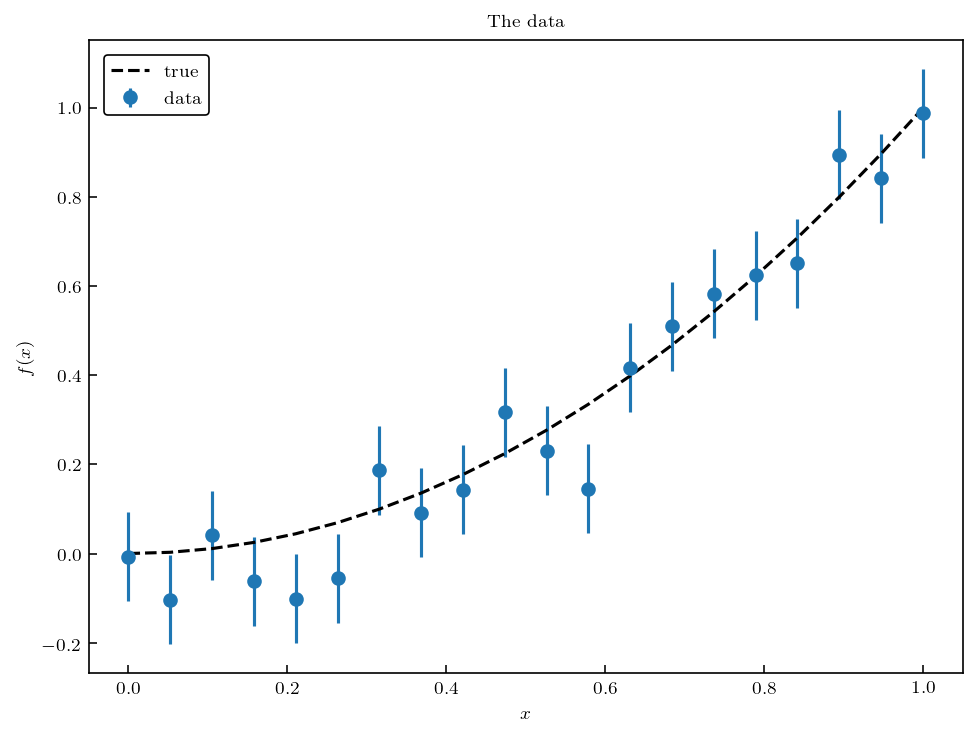

In [6]:
plt.plot(x, f(x), c='k', ls='--', label='true')
plt.errorbar(x, y, std, ls='', marker='o', label='data')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title("The data")
plt.legend();

To use a GP, we need to convert the 1d `x` input into an `NxD` matrix (since GPs can live in a `D` dimensional space, in general).
This is a `D=1` dimensional space in this example.

In [7]:
X = x[:, None]
X_star = x_star[:, None]

Begin by creating the kernel, which quantifies the correlation structure (smoothness properties) of the curves.
Then feed the kernel into a GP object, and fit it to the data we plotted above.
The radial basis function kernel (i.e., the Squared Exponential) has two hyperparameters that it depends on: the marginal variance and length scale.
Let's let the data decide which hyperparameters provide the best fit, via optimization.

In [8]:
# rbf_kernel = gptools.SquaredExponentialKernel(initial_params=[1,1], fixed_params=[True, True])
rbf_kernel = gptools.SquaredExponentialKernel(initial_params=[1.,1.], param_bounds=[(1e-9, 2), (1e-9, 2)])
gp = gptools.GaussianProcess(rbf_kernel)
gp.add_data(X, y, err_y=std)
gp.optimize_hyperparameters(max_tries=10)

(     fun: 25.183540909492386
      jac: array([-3.52859497e-05,  8.34465027e-05])
  message: 'Optimization terminated successfully.'
     nfev: 49
      nit: 11
     njev: 11
   status: 0
  success: True
        x: array([0.81900138, 0.78465578]),
 8)

That's it! Now we can get the curve of best fit and its uncertainty.

In [9]:
y_star, std_star = gp.predict(X_star, return_std=True)

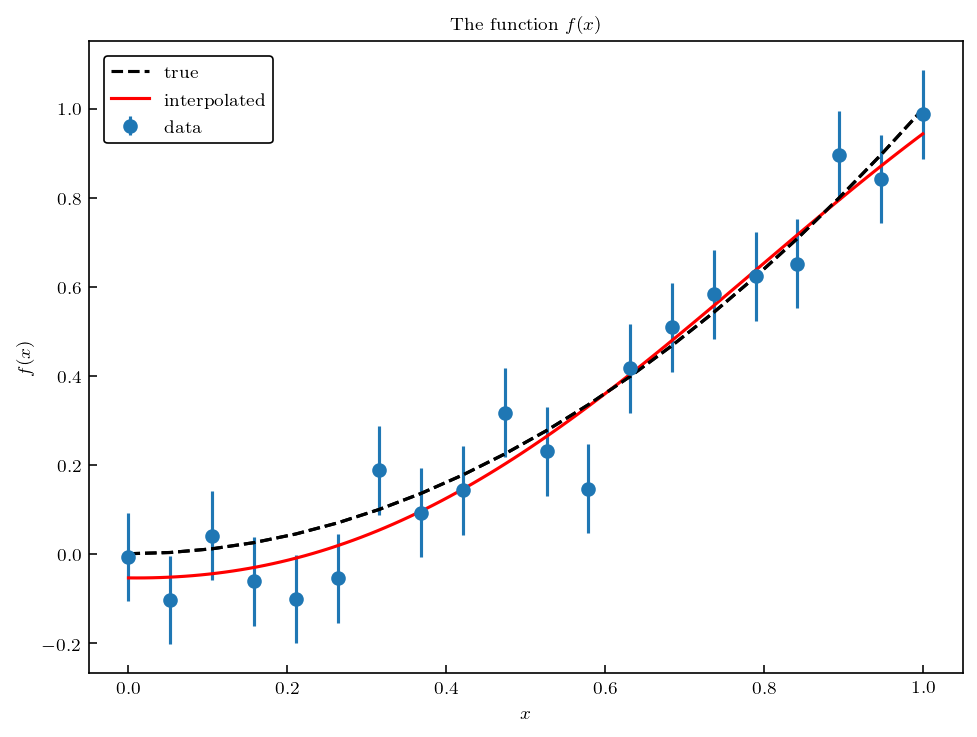

In [10]:
# set up figure
fig, ax = plt.subplots(1, 1)

# plot the data
plt.plot(x, f(x), c='k', ls='--', label='true')
plt.errorbar(x, y, std, ls='', marker='o', label='data')

# plot GP
y_star, std_star = gp.predict(X_star, return_std=True)
curve_plus_bands_plot(ax, x_star, y_star, std_star, c='r', label='interpolated')

# plot the function
plt.plot(x, f(x), c='k', ls='--')

# labels
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title("The function $f(x)$")
plt.legend();

### Estimating the derivative f'(x) <a id="estimating_derivative"></a>

Since our function is simple, we can take its derivative analytically (e.g., using SymPy) and compare to our approximation. `GPTools` allows for predicting derivatives very easily! Just use `n=1` in the `predict` method to compute the first derivative.

In [11]:
derivOrder = 1 # order of the derivative
y_prime_star, std_prime_star = gp.predict(X_star, n=derivOrder, return_std=True)

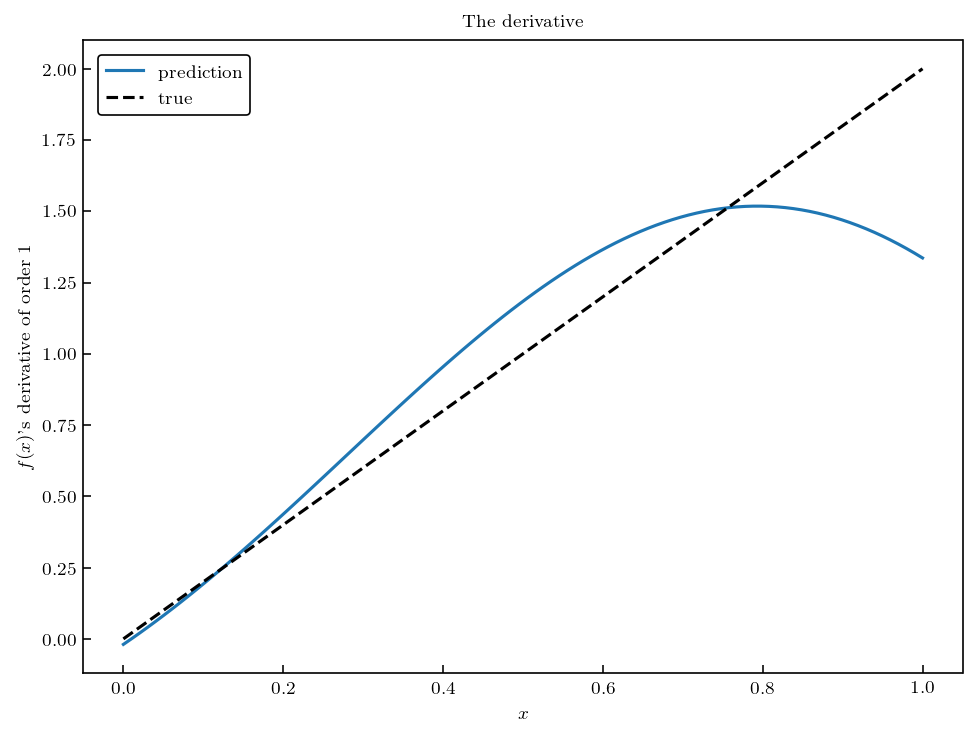

In [12]:
fig, ax = plt.subplots(1, 1)
curve_plus_bands_plot(ax, x_star, y_prime_star, std_prime_star, label="prediction")
plt.plot(x, f(x, derivOrder), c='k', ls='--', label="true")

plt.title("The derivative")
plt.xlabel('$x$');
plt.ylabel(f"$f(x)$'s derivative of order {derivOrder}")
plt.legend();

In [13]:
def draw_func_and_derivative(Xstar, kernel, X=None, y=None, err_y=None, draws=1, extra_kernel=None):
    n = Xstar.shape[0]
    XsXs = np.concatenate((Xstar, Xstar), axis=0)
    derivs = np.concatenate((np.zeros(Xstar.shape), np.ones(Xstar.shape)), axis=0)

    gp = gptools.GaussianProcess(k=kernel)
    if X is not None and y is not None:
        gp.add_data(X, y, err_y=err_y)
        gp.optimize_hyperparameters(max_tries=10)
        mean, K = gp.predict(XsXs, n=derivs, return_cov=True)
    else:
        K = gp.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)
        mean = np.zeros(2*n)
        
    if extra_kernel is not None:  # We will use this for the truncation error later
        gp_extra = gptools.GaussianProcess(k=extra_kernel)
        K += gp_extra.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)

    # The draw_sample function is much more numerically stable than
    # just using stats.multivariate_normal
    # Since we pass mean and cov, the first arguments aren't used.
    samples = gp.draw_sample(XsXs, derivs, mean=mean, cov=K, num_samp=draws)  # shape = (2n, draws)
    return samples.reshape(2, n, draws)  # separate f and f_prime by first dimension

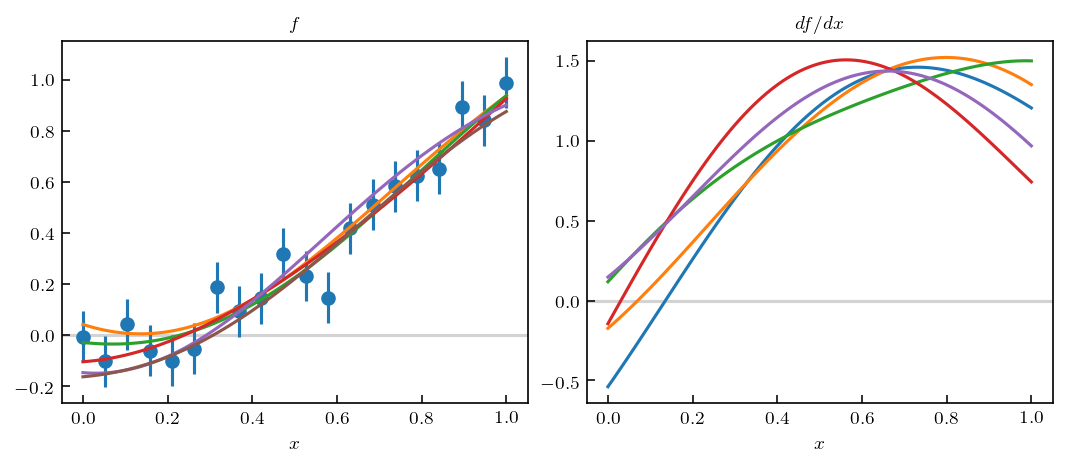

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(7, 3), sharex=True)

rbf_kernel_short = gptools.SquaredExponentialKernel(initial_params=[1, 0.25], param_bounds=[(1e-9, 2), (1e-9, 2)])

x_pred = np.linspace(0, 1, 100)


# Draw samples from fitted GP:

f_draw, fp_draw = draw_func_and_derivative(
    x_pred[:, None], rbf_kernel_short, X=X, y=y, err_y=std, draws=5)
ax1.errorbar(x, y, std, ls='', marker='o', label='data', zorder=0)


# Draw samples from unfitted GP:

# f_draw, fp_draw = draw_func_and_derivative(
#     x_pred[:, None], rbf_kernel_short, draws=5)


ax1.plot(x_pred, f_draw)
ax2.plot(x_pred, fp_draw)
ax1.set_title('$f$')
ax2.set_title('$df/dx$')
ax1.set_xlabel('$x$')
ax2.set_xlabel('$x$')
ax1.axhline(0, 0, 1, c='lightgrey', zorder=-1)
ax2.axhline(0, 0, 1, c='lightgrey', zorder=-1);

# Nuclear Matter Application <a id="nuclear_matter"></a>

Our specific use case is similar to the example above: we fit a GP to data, in this case from a physics simulation.
But there is one additional source of uncertainty from the theory error. This will also involve us creating our own custom GP kernel!

## Import the data <a id="import_data"></a>

Choices to make here:
* Select $\Lambda = 450$ or $500\,$MeV interactions with `Lambda`. (See [[arXiv:2004.07805]](https://arxiv.org/abs/2004.07805) for details.)
* Select low or high density data by setting `high_density` to `False` or `True`.

The calculated nuclear matter data for input is in the `data` directory in csv files.

In [15]:
# Lambda = 450
Lambda = 500

high_density = True
if high_density:
    filename = '../data/all_matter_data_high_density.csv'
else:
    filename = '../data/all_matter_data.csv'
    
data = InputData(filename, Lambda)


In [16]:
orders = np.array([0, 2, 3, 4])
train = slice(None, None, 5)
valid = slice(2, None, 5)

breakdown = 600

fig_path = 'manuscript_figures'

In [17]:
kf_n = data.kf_n
Kf_n = data.Kf_n
kf_s = data.kf_s
Kf_s = data.Kf_s
kf_d = data.kf_avg
Kf_d = data.Kf_avg

density = data.density

ref_2bf = data.ref_2bf
ref_n_3bf = data.ref_n_3bf
ref_s_3bf = data.ref_s_3bf
ref_d_3bf = data.ref_avg_3bf

y_s_2_plus_3bf = data.y_s_2_plus_3bf
y_n_2_plus_3bf = data.y_n_2_plus_3bf
y_d_2_plus_3bf = data.y_d_2_plus_3bf

y_s_2bf = data.y_s_2bf
y_n_2bf = data.y_n_2bf
y_d_2bf = data.y_d_2bf

y_s_3bf = data.y_s_3bf
y_n_3bf = data.y_n_3bf
y_d_3bf = data.y_d_3bf

fit_n2lo = data.fit_n2lo
fit_n3lo = data.fit_n3lo

Visualize the EOS.

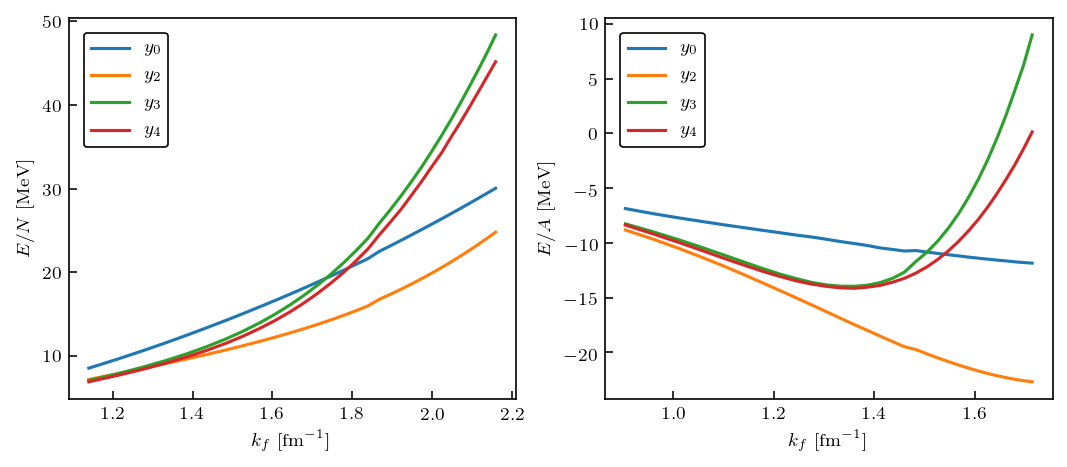

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
# fig.tight_layout(pad=2.5) 

# first neutron matter
for i, n in enumerate(orders):
    ax[0].plot(kf_n, y_n_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[0].legend()
ax[0].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[0].set_ylabel(r'$E/N$ [MeV]');

# then symmetric matter
for i, n in enumerate(orders):
    ax[1].plot(kf_s, y_s_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[1].legend()
ax[1].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[1].set_ylabel(r'$E/A$ [MeV]');

The kernel for our GP convergence model is not a simple RBF, it must be multiplied by factors related to the converges of the EFT:

\begin{align}
    \kappa(x, x';\bar c, \ell) = y_{\text{ref}}(x)y_{\text{ref}}(x') \frac{[Q(x)Q(x')]^{k+1}}{1-Q(x)Q(x')} \bar c^2 r(x,x';\ell)
\end{align}

where $\bar c^2 r(x,x';\ell)$ is the RBF kernel used above.
`GPTools` can handle products of kernels, so we just need to create a kernel object that represents the prefactor above.
I'm still not completely sure how to make a truly compatible kernel object, but the code below seems to do the trick.

In [19]:
# from gptools import ArbitraryKernel

We need to take arbitrary numbers of derivatives. Humans can make mistakes, let `SymPy` handle it.

Finally, we can create the kernel objects for our GP interpolation and derivatives. Assume some values for the hyperparameters, these would come from our convergence analysis of the observable coefficients.

In [20]:
# from functools import partial

# k_max = 4
# # eval_kernel_lower = partial(eval_kernel_scale, lowest_order=0, highest_order=k_max)
# # eval_kernel_upper = partial(eval_kernel_scale, lowest_order=k_max+1)
# eval_kernel_lower = ConvergenceKernel(lowest_order=0, highest_order=k_max)
# eval_kernel_upper = ConvergenceKernel(lowest_order=k_max+1)

# matter_rbf_kernel_n = gptools.SquaredExponentialKernel(
#     initial_params=[1,1], fixed_params=[True, True])
# matter_rbf_kernel_s = gptools.SquaredExponentialKernel(
#     initial_params=[1,1], fixed_params=[True, True])
# matter_rbf_kernel_d = gptools.SquaredExponentialKernel(
#     initial_params=[1,1], fixed_params=[True, True])

# kernel_lower_n = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_n
# kernel_upper_n = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_n

# kernel_lower_s = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_s
# kernel_upper_s = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_s

# kernel_lower_d = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_d
# kernel_upper_d = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_d


In [21]:
# N_all = 81
# density_all = np.linspace(density[0], density[-1], N_all)

density_all = np.arange(density[0], density[-1], 0.005)
N_all = len(density_all)

#neutron matter
# kf_n_all = np.linspace(kf_n[0], kf_n[-1], N_all)
kf_n_all = fermi_momentum(density_all, degeneracy=2)
Kf_n_all = kf_n_all[:, None]

#symmetric matter
# kf_s_all = np.linspace(kf_s[0], kf_s[-1], N_all)
kf_s_all = fermi_momentum(density_all, degeneracy=4)
Kf_s_all = kf_s_all[:, None]

#symmetry energy
# kf_d_all = np.linspace(kf_d[0], kf_d[-1], N_all)
kf_d_all = (kf_n_all + kf_s_all) / 2.
Kf_d_all = kf_d_all[:, None]

In [22]:
density_all

array([0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
       0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
       0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225,
       0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 ,
       0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315,
       0.32 , 0.325, 0.33 , 0.335, 0.34 ])

In [23]:
N_all

59

Begin by interpolating the data points we plotted above. This does not include truncation error yet. Also compute its derivative as before.

In [24]:
from nuclear_matter.derivatives import ObservableContainer, SymmetryEnergyContainer

In [25]:
min_uncertainty = 0.02  # Twenty keV
uncertainty_factor = 0.001  # 0.1%
# uncertainty_factor = 0.005  # 0.5%

In [26]:
err_y_n = np.abs(y_n_2_plus_3bf[:, -1]) * uncertainty_factor
err_y_n[np.abs(err_y_n) < min_uncertainty] = min_uncertainty
err_y_n

array([0.02      , 0.02      , 0.02      , 0.02      , 0.02      ,
       0.02      , 0.02      , 0.02      , 0.02      , 0.02      ,
       0.02      , 0.02      , 0.02      , 0.02      , 0.02001094,
       0.02137151, 0.02278256, 0.02447361, 0.02600839, 0.02755052,
       0.02924494, 0.0309045 , 0.03263474, 0.0342789 , 0.03615094,
       0.03790251, 0.03973538, 0.04155794, 0.04335749, 0.04513683])

In [27]:
err_y_s = np.abs(y_s_2_plus_3bf[:, -1]) * uncertainty_factor
err_y_s[np.abs(err_y_s) < min_uncertainty] = min_uncertainty
err_y_s

array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02])

In [28]:
# err_y_d = np.abs(y_d_2_plus_3bf[:, -1]) * uncertainty_factor
# err_y_d[np.abs(err_y_d) < min_uncertainty] = min_uncertainty
# err_y_d

In [29]:
err_y_d = np.sqrt(err_y_n**2 + err_y_s**2)

In [30]:
err_y_d

array([0.02828427, 0.02828427, 0.02828427, 0.02828427, 0.02828427,
       0.02828427, 0.02828427, 0.02828427, 0.02828427, 0.02828427,
       0.02828427, 0.02828427, 0.02828427, 0.02828427, 0.02829201,
       0.02927015, 0.03031576, 0.03160629, 0.03280909, 0.03404455,
       0.03542974, 0.03681152, 0.03827566, 0.03968681, 0.04131453,
       0.04285557, 0.04448483, 0.04612009, 0.047748  , 0.04936936])

In [31]:
# Old:
# std_neutron = 0.745
# ls_neutron = 0.783

# std_nuclear = 2.43
# ls_nuclear = 0.404

# std_sym_energy = 0.7968
# ls_sym_energy = 0.371

kf0_n = fermi_momentum(0.16, 2)
kf0_s = fermi_momentum(0.16, 4)

ref_neutron = 16 / kf0_n**2
ref_nuclear = 16 / kf0_s**2

if Lambda == 500:
    # New:
    std_neutron = 1.00
    ls_neutron = 0.973
    

    std_nuclear = 2.95
    ls_nuclear = 0.484

    # std_sym_energy = 0.7968
    # ls_sym_energy = 0.371
elif Lambda == 450:
    std_neutron = 0.8684060649936118
    ls_neutron = 0.7631421388401067
    std_nuclear = 2.6146499024837073
    ls_nuclear = 0.46603268529311087


if Lambda == 450:
#     rho = 0.75
    rho = 0.95
    ls_n_sym = (ls_neutron + ls_nuclear) / 2
    ls_s_sym = None
elif Lambda == 500:
    rho = None
    ls_n_sym = ls_neutron
    ls_s_sym = ls_nuclear

In [32]:
setup_time_start = time.time()
verbose = True

print('Setting up neutron matter...', flush=True)
obs_neutron = ObservableContainer(
    density=density,
    kf=kf_n,
    y=y_n_2_plus_3bf,
    orders=orders,
    density_interp=density_all,
    kf_interp=kf_n_all,
    std=std_neutron,
    ls=ls_neutron,
    ref=ref_neutron,
    breakdown=breakdown,
    err_y=err_y_n,
    include_3bf=False,
    derivs=[0, 1, 2],
    verbose=verbose,
)

print('Setting up nuclear matter...', flush=True)
obs_nuclear = ObservableContainer(
    density=density,
    kf=kf_s,
    y=y_s_2_plus_3bf,
    orders=orders,
    density_interp=density_all,
    kf_interp=kf_s_all,
    std=std_nuclear,
    ls=ls_nuclear,
    ref=ref_nuclear,
    breakdown=breakdown,
    err_y=err_y_s,
    include_3bf=False,
    derivs=[0, 1, 2],
    verbose=verbose,
)

print('Setting up symmetry energy...', flush=True)
# obs_sym_energy = ObservableContainer(
#     density=density,
#     kf=kf_d,
#     y=y_d_2_plus_3bf,
#     orders=orders,
#     density_interp=density_all,
#     kf_interp=kf_d_all,
#     std=std_sym_energy,
#     ls=ls_sym_energy,
#     breakdown=breakdown,
#     err_y=err_y_d,
#     include_3bf=False,
#     derivs=[0, 1, 2],
#     verbose=verbose,
# )
obs_sym_energy = SymmetryEnergyContainer(
    density=density,
    y=y_d_2_plus_3bf,
    orders=orders,
    density_interp=density_all,
    std_n=std_neutron,
    ls_n=ls_n_sym,
    std_s=std_nuclear,
    ls_s=ls_s_sym,
    ref_n=ref_neutron,
    ref_s=ref_nuclear,
    breakdown=breakdown,
    err_y=err_y_d,
    include_3bf=False,
    derivs=[0, 1],
    verbose=verbose,
    rho=rho,
)

print('Setup time:', time.time() - setup_time_start)

Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 10
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 10
For EFT order 4, the best polynomial has max nu = 10
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 8
For EFT order 2, the best polynomial has max nu = 8
For EFT order 3, the best polynomial has max nu = 8
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
0.973 0.484 0.8119689713375328
For EFT order 0, the best polynomial has max nu = 7
For EFT order 2, the best polynomial has max nu = 7
For EFT order 3, the best polynomial has max nu = 7
For EFT order 4, the best polynomial has max nu = 8
Setup time: 15.649042844772339


These are the coefficients $c_\nu$ from fitting the functional
\begin{align}
    \sum_{\nu = 2}^M c_\nu \left(\frac{n}{n_0}\right)^{\nu/3}
\end{align}
to each energy per particle

In [33]:
obs_neutron.compute_functional_coefficients_df()

,EFT Order 0,EFT Order 2,EFT Order 3,EFT Order 4
nu,,,,
2,36160.0,698.938477,21728.0,114016.0
3,-435456.0,-4249.770508,-344832.0,-1114880.0
4,1793024.0,10943.771484,1505280.0,4318208.0
5,-3878912.0,-14873.640625,-3313664.0,-9160704.0
6,5107712.0,11209.095703,4407296.0,11950080.0
7,-4261888.0,-4436.011719,-3694592.0,-9887744.0
8,2198528.0,720.896118,1916928.0,5074944.0
9,-644096.0,NaN,-564480.0,-1477632.0
10,82016.0,NaN,72192.0,187072.0


In [34]:
obs_nuclear.compute_functional_coefficients_df()

,EFT Order 0,EFT Order 2,EFT Order 3,EFT Order 4
nu,,,,
2,979.839111,511.899170,1419.909546,-21.998624
3,-6252.257812,-3535.302734,-9232.950439,-134.812969
4,16037.478516,9529.062500,24155.417969,597.873795
5,-21582.130859,-13370.296875,-32979.111328,-930.536316
6,16138.066406,10343.214844,24812.169922,621.639278
7,-6367.779297,-4194.089844,-9772.480469,-146.264211
8,1036.883179,698.612549,1583.045776,NaN


In [35]:
obs_sym_energy.compute_functional_coefficients_df()

,EFT Order 0,EFT Order 2,EFT Order 3,EFT Order 4
nu,,,,
2,-49.016113,138.587353,-14.829033,1052.512939
3,498.802811,-438.911423,456.068893,-6192.923828
4,-1084.764557,777.340149,-1272.497040,15653.753906
5,1094.303284,-738.425873,1515.217316,-21014.523438
6,-532.501190,365.781738,-805.112900,15740.183594
7,101.200489,-74.191422,152.410278,-6216.380859
8,NaN,NaN,NaN,1007.821289


Let's see how we did. The light grey error bands represent 2 standard deviations.
The left plot shows the interpolant alone, with error bands that are so small they can't be seen.
The right plot is the same as the left, except truncation bands are added.

In [36]:
def highlight_nsat(ax, nsat=0.164, zorder=0, band=False):
    ax.axvline(nsat, ls="--", lw=0.8, c='0.1', zorder=zorder)
    if band:
        import matplotlib.transforms as transforms
        trans = transforms.blended_transform_factory(
            ax.transData, ax.transAxes)
        n0_std = 0.007
        rect = mpatches.Rectangle(
            (nsat-n0_std, 0), width=2*n0_std, height=1,
            transform=trans, facecolor='0.85', edgecolor='0.6',
            linewidth=0.6,
            alpha=0.7, zorder=zorder-0.01
        )
        ax.add_patch(rect)


density_label = r'Density $n$ [fm$^{-3}$]'


def plot_with_and_without_truncation(
    density, y, std, std_with_trunc, density_data=None, y_data=None, add_nsat=True, axes=None, c=None, zorder=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
    ax1, ax2 = axes
    plot_obs_vs_density(
        density=density, y=y, std=std, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax1, c=c, zorder=zorder,
        **kwargs
    )
    plot_obs_vs_density(
        density=density, y=y, std=std_with_trunc, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax2, c=c, zorder=zorder,
        **kwargs
    )
    return axes

def plot_obs_vs_density(
    density, y, std, density_data=None, y_data=None, add_nsat=True, ax=None, c='k',
    color_68=None, color_95=None, markersize=3, edgecolor=None, zorder=0,
    **kwargs
):
    if ax is None:
        fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
    curve_plus_bands_plot(
        ax, density, y, std, c=c, color_68=color_68, color_95=color_95,
        edgecolor=edgecolor, zorder=zorder, **kwargs
    )
    ax.set_xlabel(density_label)
    ax.margins(x=0)
    
    if y_data is not None:
        c_marker = c if c is not None else 'k'
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
        ax.plot(
            density_data, y_data, ls='', marker='o', c=c_marker, markersize=markersize,
            zorder=zorder, **kwargs
        )
    if add_nsat:
        highlight_nsat(ax, zorder=zorder)

    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    return ax


def plot_obs_panels(density, y, dy, orders, density_data=None, y_data=None, colors=None, axes=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(2, 2, sharey='row', sharex='col', figsize=(3.4, 3.4))
    fig = plt.gcf()
    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.2/72)
    
    if colors is None:
        color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
        cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
        colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
    
    light_colors = [lighten_color(color) for color in colors]
    dark_colors = [lighten_color(color, 1.5) for color in colors]

    for j, ax in enumerate(axes.ravel()):
        for i, n in enumerate(orders[:j+1]):
            if y_data is not None:
                y_data_i = y_data[:, i]
            else:
                y_data_i = None

            plot_obs_vs_density(
                density,
                y[:, i],
                dy[:, i],
                ax=ax,
#                 color_68=colors[i],
#                 color_95=light_colors[i],
#                 c=dark_colors[i],
                c=colors[i],
                color_68=light_colors[i],
                edgecolor=colors[i],
                add_nsat=i==j,
                zorder=i/3,
                density_data=density_data,
                y_data=y_data_i,
                markersize=3,
                **kwargs
            )
        ax.axhline(0, 0, 1, c='k', lw=0.8)
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(right=True, top=True, which='both')
    add_top_order_legend(fig, axes[0, 0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
    axes[0,0].set_xlabel('')
    axes[0,1].set_xlabel('')
    return fig, axes

In [37]:
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [38]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

In [39]:
from os.path import join

In [40]:
order_labels = ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO']

This is proof that finite differences can perform poorly for second derivatives:

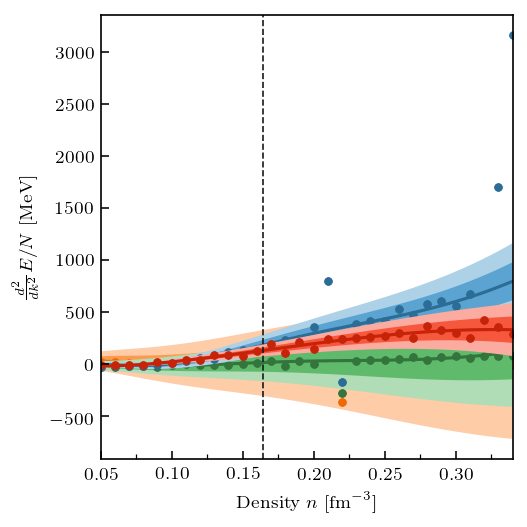

In [41]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
for i, n in enumerate(orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=2),
        obs_nuclear.get_std(order=n, deriv=2, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==len(orders)-1,
        zorder=i/10,
        density_data=density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=2, wrt_kf=True),
#         y_data=obs_nuclear.poly_interp(order=n, deriv=2, density=obs_nuclear.density) / \
#             kf_derivative_wrt_density(obs_nuclear.kf, obs_nuclear.density),
    )
ax.set_ylabel(r'$\frac{d^2}{dk^2} E/N$ [MeV]');

Create a Gaussian random variable based on the posterior for the saturation density found for our Hamiltonians.
Sample saturation densities from it.

In [42]:
sat_density_ham_dist = stats.norm(0.17, 0.01)
sat_density_ham_dist_n2lo = stats.norm(0.17, 0.02)
num_sats = 101

np.random.seed(1)
d_sats = sat_density_ham_dist.rvs(num_sats)
d_sats_n2lo = sat_density_ham_dist_n2lo.rvs(num_sats)
D_sats = d_sats[:, None]

kf_n_sats = fermi_momentum(d_sats, 2)
Kf_n_sats = kf_n_sats[:, None]

kf_s_sats = fermi_momentum(d_sats, 4)
Kf_s_sats = kf_s_sats[:, None]

These will be used later on to get posteriors with full uncertainties for the incompressibility $K$, and $S_v$--$L$ correlations

## Make Order-by-Order Predictions with Uncertainties <a id="order_by_order"></a>

Our GPs are defined to be stationary over momentum, but most formula for EOS properties use derivatives with respect to density.
So our derivatives must make use of the chain rule.
This is all handled inside functions like `compute_pressure`, `compute_pressure_cov`, etc., which can all be told whether the inputs use `kf` or `n` as the space for derivatives.

In [43]:
from nuclear_matter import kf_derivative_wrt_density

The pressure is given by
$$ 
P = n^2 \frac{d}{dn} \frac{E}{A} = n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = n \frac{k_f}{3} \frac{d}{dk_f}  \frac{E}{A}
$$
where $k_f = \sqrt[3]{3\pi^2\, n/2}$ ($k_f = \sqrt[3]{3\pi^2\, n}$) for symmetric (neutron) matter.

It is useful to note that
\begin{align}
    \frac{dk}{dn} & = \frac{k}{3n} \\
    \frac{d^2k}{dn^2} & = -\frac{2k}{9n^2}
\end{align}

Text(0.1, 0.9, '$E/A \\pm 1\\sigma$\n[MeV]')

/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


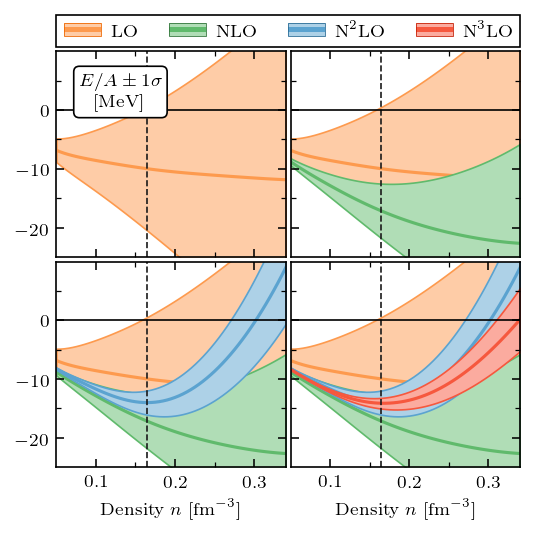

In [44]:
energies_s = np.array([obs_nuclear.get_pred(order=n, deriv=0) for n in orders]).T
energy_s_stds = np.array([obs_nuclear.get_std(order=n, deriv=0, include_trunc=True) for n in orders]).T


fig, axes = plot_obs_panels(
    density_all, y=energies_s, dy=energy_s_stds, orders=orders,
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(-25, 10-1e-5)
axes[1, 0].set_ylim(-25, 10-1e-5)
label = r"""$E/A \pm 1\sigma$
[MeV]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
# fig.savefig(join(fig_path, f'energy_obs-s_panels_Lambda-{Lambda}'))


/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


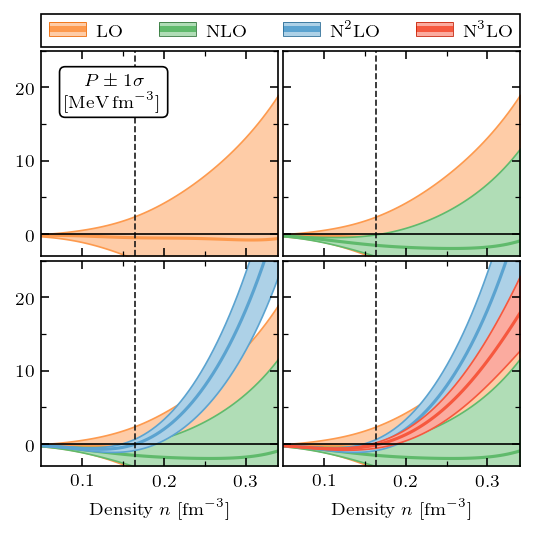

In [45]:
pressures_s = []
pressure_s_stds = []
pressure_s_fits = []
for i, n in enumerate(orders):
    pressure_s = compute_pressure(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        dE=obs_nuclear.get_pred(order=n, deriv=1)
    )
    pressure_s_cov = compute_pressure_cov(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        dE_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1)
    )
    pressure_s_std = np.sqrt(np.diag(pressure_s_cov))

    pressure_alt_diff_s = compute_pressure(
        obs_nuclear.density,
        obs_nuclear.kf,
        dE=obs_nuclear.poly_interp(order=n, deriv=1, wrt_kf=False),
        wrt_kf=False
    )
    pressures_s.append(pressure_s)
    pressure_s_stds.append(pressure_s_std)
    pressure_s_fits.append(pressure_alt_diff_s)

pressures_s = np.array(pressures_s).T
pressure_s_stds = np.array(pressure_s_stds).T
pressure_s_fits = np.array(pressure_s_fits).T

fig, axes = plot_obs_panels(
    density_all, y=pressures_s, dy=pressure_s_stds, orders=orders,
#     density_data=density[::3], y_data=pressure_s_fits[::3],
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(-3, 25)
axes[1, 0].set_ylim(-3, 25)
label = r"""$P \pm 1\sigma$
[MeV\,fm$^{-3}$]"""
axes[0, 0].text(
    0.1, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
fig.savefig(join(fig_path, f'pressure_sym_panels_Lambda-{Lambda}'))


$$
L(n) = 3\,n \, \frac{d}{dn} E_\text{sym}(n) = 3n \frac{dk_f}{dn} \frac{d}{dn} E_\text{sym}(n)
     = 3\,n \, \frac{k_f}{3n} \frac{d}{dk_f}  E_\text{sym}(n) = k_f \frac{d}{dk_f} E_\text{sym}(n)
$$

/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


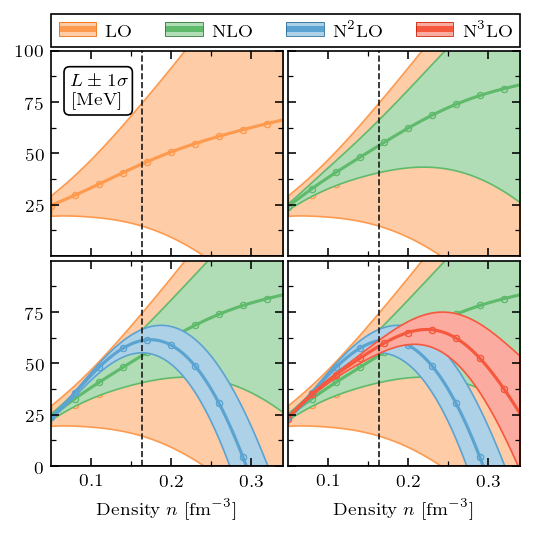

In [46]:
slopes = []
slope_stds = []
slope_fits = []

for i, n in enumerate(orders):
    slope = compute_slope(
        obs_sym_energy.density_interp,
        obs_sym_energy.kf_interp,
        dS2=obs_sym_energy.get_pred(order=n, deriv=1),
        wrt_kf=False
    )
    slope_cov = compute_slope_cov(
        obs_sym_energy.density_interp,
        obs_sym_energy.kf_interp,
        dS2_cov=obs_sym_energy.get_cov(order=n, deriv1=1, deriv2=1),
        wrt_kf=False
    )
    slope_std = np.sqrt(np.diag(slope_cov))

#     slope_alt_diff = compute_slope(
#         obs_sym_energy.density,
#         obs_sym_energy.kf,
#         dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=True)
#     )
#     slope_alt_diff = compute_slope(
#         obs_sym_energy.density,
#         obs_sym_energy.kf,
#         dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=False),
#         wrt_kf=False
#     )
    slope_alt_diff = compute_slope(
        obs_sym_energy.density,
        obs_sym_energy.kf,
        dS2=obs_sym_energy.poly_interp(order=n, deriv=1, wrt_kf=False),
        wrt_kf=False
    )
    
    slopes.append(slope)
    slope_stds.append(slope_std)
    slope_fits.append(slope_alt_diff)

slopes = np.array(slopes).T
slope_stds = np.array(slope_stds).T
slope_fits = np.array(slope_fits).T
    
fig, axes = plot_obs_panels(
    density_all, y=slopes, dy=slope_stds, orders=orders,
    density_data=density[::3], y_data=slope_fits[::3],
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(1e-3, 100)
axes[1, 0].set_ylim(0, 100-1e-3)
label = r"""$L \pm 1\sigma$
[MeV]"""
for ax in axes.ravel():
    ax.yaxis.set_major_locator(MultipleLocator(25))
axes[0, 0].text(
    0.08, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)

fig.savefig(join(fig_path, f'slope_panels_Lambda-{Lambda}'))

<!-- $$ 
K(n) = 9 \, n^2 \frac{d}{dn} \frac{E}{A} = 9 \, n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = 9 \, n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = 3 \, n \, k_f \frac{d}{dk_f}  \frac{E}{A}
$$ -->

\begin{align}
    K(n) = 9 n^2 \frac{d^2}{dn^2} \frac{E}{A} = 9 n^2 \left[\frac{d^2k_f}{dn^2} \left(\frac{d}{dk_f} \frac{E}{A}\right) + \left(\frac{dk_f}{dn}\right)^2 \frac{d^2}{dk_f^2} \frac{E}{A} \right]
\end{align}

/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


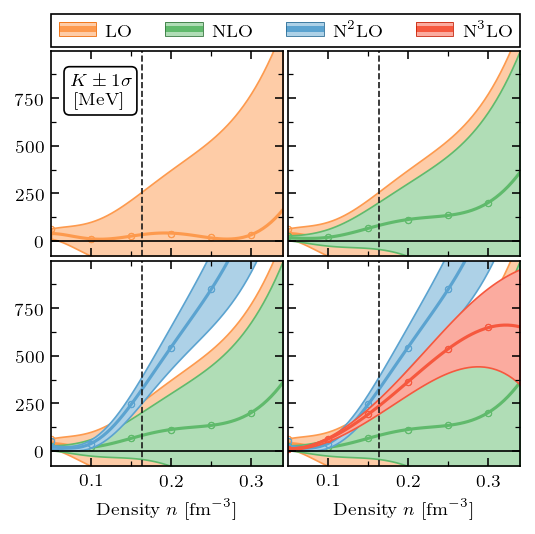

In [47]:
K_incomps = []
K_incomp_stds = []
K_incomp_fits = []

for i, n in enumerate(orders):
    K_incomp = compute_compressibility(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        d2E=obs_nuclear.get_pred(order=n, deriv=2),
        dE=obs_nuclear.get_pred(order=n, deriv=1),
    )
    K_incomp_cov = compute_compressibility_cov(
        obs_nuclear.density_interp,
        obs_nuclear.kf_interp,
        d2E_cov=obs_nuclear.get_cov(order=n, deriv1=2, deriv2=2),
        dE_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1),
        dE_d2E_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=2),
    )
    K_incomp_std = np.sqrt(np.diag(K_incomp_cov))

    # Derivative wrt kf and n differ!
#     K_incomp_alt_diff = compute_compressibility(
#         obs_neutron.density,
#         obs_neutron.kf,
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=True),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True),
#     )
#     K_incomp_alt_diff = compute_compressibility(
#         obs_neutron.density,
#         obs_neutron.kf,
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=False),
#         wrt_kf=False
#     )
    K_incomp_alt_diff = compute_compressibility(
        obs_nuclear.density,
        obs_nuclear.kf,
        d2E=obs_nuclear.poly_interp(order=n, deriv=2, wrt_kf=False),
#         d2E=obs_nuclear.spline(obs_nuclear.density, order=n, deriv=2),
        wrt_kf=False
    )
    
    K_incomps.append(K_incomp)
    K_incomp_stds.append(K_incomp_std)
    K_incomp_fits.append(K_incomp_alt_diff)

    
K_incomps = np.array(K_incomps).T
K_incomp_stds = np.array(K_incomp_stds).T
K_incomp_fits = np.array(K_incomp_fits).T
    
fig, axes = plot_obs_panels(
    density_all, y=K_incomps, dy=K_incomp_stds, orders=orders,
    density_data=density[::5], y_data=K_incomp_fits[::5],
    colors=colors, fillstyle='none', markeredgewidth=0.5,
)

axes[0, 0].set_ylim(-80, 999)
axes[1, 0].set_ylim(-80, 999)
label = r"""$K \pm 1\sigma$
[MeV]"""
axes[0, 0].text(
    0.08, 0.9, label, transform=axes[0,0].transAxes, ha='left', va='top',
    multialignment='center', zorder=10,
    bbox=dict(facecolor='w', boxstyle='round')
)
fig.savefig(join(fig_path, f'incomp_sym_panels_Lambda-{Lambda}'))
plt.show()
    
# axes[0,0].set_ylabel('Compressibility $K$')
# axes[1,0].set_ylabel('Compressibility $K$')
# axes[0,0].set_xlabel('')
# axes[0,1].set_xlabel('');

In [48]:
num_sats

101

In [49]:
np.random.seed(1)

K_sat_samples = {}

for i, n in enumerate(orders):
    dE_and_d2E_s_sats, dE_and_d2E_s_sats_cov = obs_nuclear.predict(Kf_s_sats, order=n, derivs=[1, 2])
    dE_s_sats = dE_and_d2E_s_sats[:num_sats]
    d2E_s_sats = dE_and_d2E_s_sats[num_sats:]

    dE_s_sats_cov = dE_and_d2E_s_sats_cov[:num_sats, :num_sats]
    d2E_s_sats_cov = dE_and_d2E_s_sats_cov[num_sats:, num_sats:]
    dE_d2E_s_sats_cov = dE_and_d2E_s_sats_cov[:num_sats, num_sats:]
    # d2E_n_sats, d2E_n_sats_cov = obs_neutron.predict(D_sats, order=n, deriv=2)

    K_incomp_sats = compute_compressibility(
        d_sats,
        kf_s_sats,
        d2E=d2E_s_sats,
        dE=dE_s_sats,
    )
    K_incomp_sats_cov = compute_compressibility_cov(
        d_sats,
        kf_s_sats,
        d2E_cov=d2E_s_sats_cov,
        dE_cov=dE_s_sats_cov,
        dE_d2E_cov=dE_d2E_s_sats_cov,
    )
    K_incomp_sats_std = np.sqrt(np.diag(K_incomp_sats_cov))

    K_incomp_sats_sampled = stats.norm(K_incomp_sats, K_incomp_sats_std).rvs((1000, num_sats))
    K_sat_samples[n] = K_incomp_sats_sampled.ravel()

In [50]:
K_sat_samples

{0: array([ 512.09510165, -105.42233867,  -87.18619611, ...,  138.84933262,
        -257.82314436,  230.36424094]),
 2: array([ 220.635707  ,   38.72146371,  160.48165601, ...,  -37.33559666,
          30.43652149, -131.79962505]),
 3: array([431.6651239 , 403.56474377, 439.49200757, ..., 111.56633821,
        542.87457686, 350.81825367]),
 4: array([324.41867287, 182.92769798, 236.68315863, ..., 160.20709915,
        205.21525172, 186.63055428])}

In [51]:
K_sat_df = pd.DataFrame.from_dict(K_sat_samples)
K_sat_df.columns = order_labels
K_sat_df = pd.melt(K_sat_df, var_name='Order', value_name=r'$K$ [MeV]')

In [52]:
K_sat_df

,Order,$K$ [MeV]
0,LO,512.095102
1,LO,-105.422339
2,LO,-87.186196
3,LO,-199.754405
4,LO,271.175831
...,...,...
403995,N$^{3}$LO,175.539568
403996,N$^{3}$LO,335.888660
403997,N$^{3}$LO,160.207099
403998,N$^{3}$LO,205.215252


In [53]:
K_sat_df.to_csv(f'K_sat_data_Lambda-{Lambda}.csv', index=False)

In [54]:
import seaborn as sns

In [55]:
K_sat_df['Order'].unique()

array(['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO'], dtype=object)

In [56]:
K_sat_means = {}
K_sat_stds = {}
for i, n in enumerate(orders):
    K_sat_means[n] = K_sat_df.loc[K_sat_df['Order'] == order_labels[i], r'$K$ [MeV]'].mean()
    K_sat_stds[n] = K_sat_df.loc[K_sat_df['Order'] == order_labels[i], r'$K$ [MeV]'].std()

In [57]:
K_sat_means

{0: 37.389778100037816,
 2: 88.54232653098032,
 3: 365.28888007072095,
 4: 259.56668051073774}

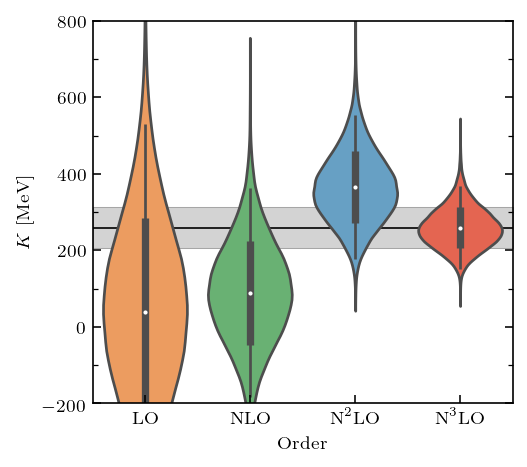

In [58]:

fig, ax = plt.subplots(figsize=(3.4, 3))
sns.violinplot(
    y='$K$ [MeV]', x='Order', data=K_sat_df, orient='v',
    palette=colors, saturation=0.8,
    scale='width', inner=None, cut=0, ax=ax, edgecolor='w', linewidth=1.3
)

my_gray = '0.3'
for col in ax.collections:
    col.set_edgecolor(my_gray)

for i, n in enumerate(orders):
    ax.plot(
        [i, i], [K_sat_means[n] - 2*K_sat_stds[n], K_sat_means[n] + 2*K_sat_stds[n]],
        c=my_gray, lw=1.3, solid_capstyle='butt', zorder=1
    )
    ax.plot(
        [i, i], [K_sat_means[n] - K_sat_stds[n], K_sat_means[n] + K_sat_stds[n]],
        c=my_gray, lw=3.5, solid_capstyle='butt', zorder=1
    )
    ax.plot([i], [K_sat_means[n]], ls='', marker='.', c='w', markersize=2, zorder=1)

ax.set_xlim(-0.5, 3.5)
ax.axhline(K_sat_means[4], 0, 1, c='k', zorder=-1, lw=0.8)
ax.fill_between(
    ax.get_xlim(),
    [K_sat_means[4] + K_sat_stds[4]]*2,
    [K_sat_means[4] - K_sat_stds[4]]*2,
    facecolor='lightgrey', edgecolor='0.65', lw=0.5, zorder=-3
)

# ax.yaxis.set_major_locator(MultipleLocator(400))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(right=True, which='both')
ax.set_ylim(-200, 800)

fig.savefig(join(fig_path, f'K_sat_marginalized_Lambda-{Lambda}'))

In [59]:
K_incomp_sats

array([314.01546613, 236.59885633, 239.39323326, 221.35190676,
       287.2016472 , 182.32344539, 318.30866151, 231.62583583,
       268.20529058, 248.77938246, 308.2480495 , 189.79505608,
       246.31066782, 244.23275639, 296.63235099, 220.47123343,
       251.38685342, 227.76553776, 258.6982272 , 277.33997567,
       220.44743735, 297.01856589, 288.46960259, 274.55095014,
       288.44384273, 234.2001988 , 253.06943023, 225.85620813,
       248.15292543, 275.51766184, 233.93623986, 243.8052397 ,
       234.08556473, 228.84418835, 234.61568829, 256.82375788,
       219.90200046, 265.29011889, 315.27816842, 282.88746986,
       250.72848283, 227.44306948, 232.09201311, 316.4416794 ,
       258.99208497, 235.75689261, 263.79460967, 331.02258385,
       261.36650777, 278.53598494, 267.55461931, 245.30435109,
       219.07903265, 245.40236513, 250.15016578, 277.4723602 ,
       286.27640221, 289.50461062, 267.05199928, 287.89302184,
       231.8517448 , 300.83645001, 274.91294441, 247.13

In [60]:

K_incomp_mean_marg = np.mean(K_incomp_sats_sampled)
K_incomp_std_marg = np.std(K_incomp_sats_sampled)

In [61]:
print(f'K = {K_incomp_mean_marg} +/- {K_incomp_std_marg}')

K = 259.5666805107356 +/- 53.94456713239951


In [62]:
K_incomp_mean_marg

259.5666805107356

In [63]:
K_incomp_std_marg

53.94456713239951

In [64]:
K_incomp_stds.shape

(59, 4)

In [65]:
density_all.shape

(59,)

In [66]:
density_all

array([0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
       0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
       0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225,
       0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 ,
       0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315,
       0.32 , 0.325, 0.33 , 0.335, 0.34 ])

In [67]:
(density_all - 0.16)

array([-1.10000000e-01, -1.05000000e-01, -1.00000000e-01, -9.50000000e-02,
       -9.00000000e-02, -8.50000000e-02, -8.00000000e-02, -7.50000000e-02,
       -7.00000000e-02, -6.50000000e-02, -6.00000000e-02, -5.50000000e-02,
       -5.00000000e-02, -4.50000000e-02, -4.00000000e-02, -3.50000000e-02,
       -3.00000000e-02, -2.50000000e-02, -2.00000000e-02, -1.50000000e-02,
       -1.00000000e-02, -5.00000000e-03, -5.55111512e-17,  5.00000000e-03,
        1.00000000e-02,  1.50000000e-02,  2.00000000e-02,  2.50000000e-02,
        3.00000000e-02,  3.50000000e-02,  4.00000000e-02,  4.50000000e-02,
        5.00000000e-02,  5.50000000e-02,  6.00000000e-02,  6.50000000e-02,
        7.00000000e-02,  7.50000000e-02,  8.00000000e-02,  8.50000000e-02,
        9.00000000e-02,  9.50000000e-02,  1.00000000e-01,  1.05000000e-01,
        1.10000000e-01,  1.15000000e-01,  1.20000000e-01,  1.25000000e-01,
        1.30000000e-01,  1.35000000e-01,  1.40000000e-01,  1.45000000e-01,
        1.50000000e-01,  

In [68]:
# def compute_Esym_L(kf, S2_dS2, S2_dS2_cov):
#     to_Esym_L_mat = np.array([
#         [1, 0],
#         [0, kf]
#     ])
#     S2_L = to_Esym_L_mat @ S2_dS2
#     S2_L_cov = to_Esym_L_mat @ S2_dS2_cov @ to_Esym_L_mat.T
#     return S2_L, S2_L_cov

def compute_Esym_L(n, S2_dS2, S2_dS2_cov):
    to_Esym_L_mat = np.array([
        [1, 0],
        [0, 3*n]
    ])
    S2_L = to_Esym_L_mat @ S2_dS2
    S2_L_cov = to_Esym_L_mat @ S2_dS2_cov @ to_Esym_L_mat.T
    return S2_L, S2_L_cov

In [69]:
density_emp_sat = np.array([0.164])
Density_emp_sat = density_emp_sat[:, None]
# Kf_n_sat = fermi_momentum(density_sat, 2)[:, None]
# Kf_s_sat = fermi_momentum(density_sat, 4)[:, None]
# Kf_d_sat = (Kf_n_sat + Kf_s_sat) / 2.

Esym_dEsym_mean_emp, Esym_dEsym_cov_emp = obs_sym_energy.predict(Density_emp_sat, order=4, derivs=[0, 1])
Esym_L_mean_emp, Esym_L_cov_emp = compute_Esym_L(Density_emp_sat[0, 0], Esym_dEsym_mean_emp, Esym_dEsym_cov_emp)

In [70]:

# K_n_sats = fermi_momentum(d_sats, 2)[:, None]
# K_s_sats = fermi_momentum(d_sats, 4)[:, None]
# K_d_sats = (K_n_sats + K_s_sats) / 2.
Esym_dEsym_means, Esym_dEsym_cov = obs_sym_energy.predict(D_sats, order=4, derivs=[0, 1])

Esym_L_samples = []
for n_s in range(num_sats):
    # Get S2(kf_i) and dS2(kf_i). The vector and matrices are blocks for each derivative type
    Esym_dEsym_mean_n = Esym_dEsym_means[[n_s, n_s+num_sats]]
    Esym_dEsym_cov_n = Esym_dEsym_cov[[n_s, n_s+num_sats]][:, [n_s, n_s+num_sats]]
    Esym_L_mean_n, Esym_L_cov_n = compute_Esym_L(D_sats[n_s,0], Esym_dEsym_mean_n, Esym_dEsym_cov_n)
    Esym_L_samples.append(
        stats.multivariate_normal(mean=Esym_L_mean_n, cov=Esym_L_cov_n, allow_singular=True).rvs(num_sats)
    )
Esym_L_samples = np.asarray(Esym_L_samples).reshape(-1, 2).T

# Create a mean and covariance matrix from all of the samples
Esym_L_samples_mean = np.mean(Esym_L_samples, axis=1)
Esym_L_samples_cov = np.cov(Esym_L_samples)

Show the $S_v$--$L$ plot *without* making any Gaussian approximation. Looks like a Gaussian!

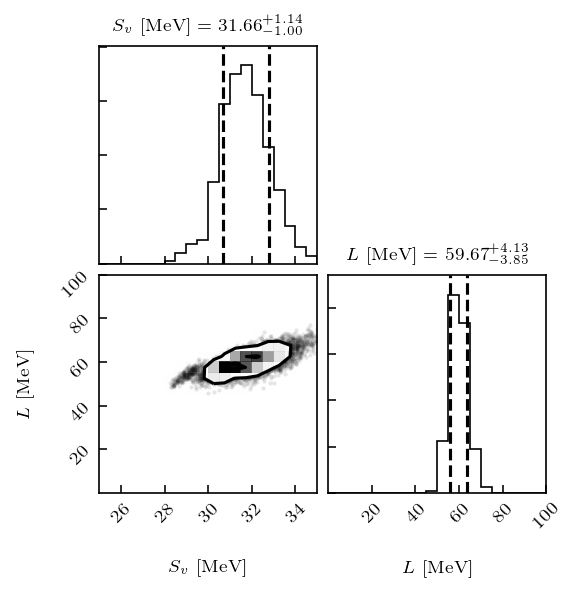

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=False)
fig = corner.corner(
    Esym_L_samples.T, range=[(25, 35), (0, 100)],
    labels=[r'$S_v$ [MeV]', r'$L$ [MeV]'], fig=fig,
    quantiles=(0.16, 0.84), levels=(1-np.exp(-0.5), 1-np.exp(-0.5*2**2)),
    show_titles=True, title_kwargs={"fontsize": 9}
)

In [72]:
print('mean:\n', Esym_L_samples_mean)
print('cov:\n', Esym_L_samples_cov)

mean:
 [31.69810539 59.830485  ]
cov:
 [[ 1.23651375  3.27499281]
 [ 3.27499281 16.95157735]]


In [73]:
print(f'S_v = {Esym_L_samples_mean[0]:0.1f} +/- {np.sqrt(Esym_L_samples_cov[0, 0]):0.1f}')
print(f'L = {Esym_L_samples_mean[1]:0.1f} +/- {np.sqrt(Esym_L_samples_cov[1, 1]):0.1f}')

S_v = 31.7 +/- 1.1
L = 59.8 +/- 4.1


In [74]:
Esym_L_mean_emp

array([30.93438443, 58.47545891])

In [75]:
Esym_L_cov_emp

array([[ 0.13982695,  1.09064825],
       [ 1.09064825, 10.61924441]])

In [76]:
np.linalg.eigh(Esym_L_cov_emp)

(array([ 0.02752099, 10.73155037]),
 array([[-0.9947402 ,  0.10243014],
        [ 0.10243014,  0.9947402 ]]))

In [77]:
Esym_L_samples_mean - Esym_L_mean_emp

array([0.76372096, 1.35502609])

Ellipse(xy=(0, 0), width=2.7532090628194874, height=0.6479505045978737, angle=0)


(0, 100)

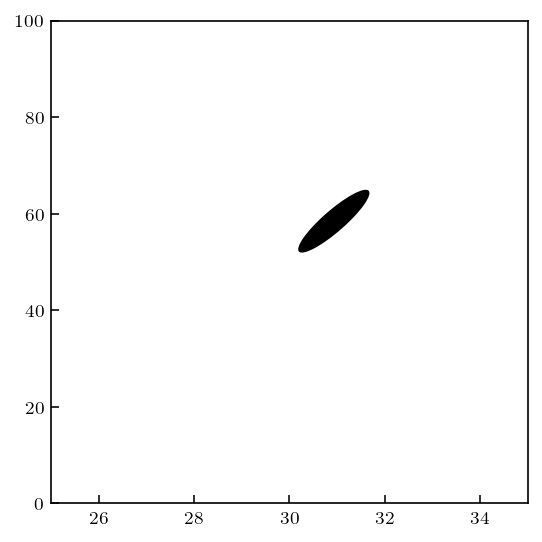

In [78]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
pat = confidence_ellipse_mean_cov(Esym_L_mean_emp, Esym_L_cov_emp, ax=ax, n_std=2, facecolor='k')
print(pat)
ax.set_xlim(25, 35)
ax.set_ylim(0, 100)

In [79]:

# density_sat = np.array([0.16, 0.16])
# Kf_n_sat = fermi_momentum(density_sat, 2)[:, None]
# Kf_s_sat = fermi_momentum(density_sat, 4)[:, None]
# # Kf_d_sat = (Kf_n_sat + Kf_s_sat) / 2.
# Kf_d_sat = Kf_n_sat
# Esym_L_sat_derivs = np.array([[0], [1]])
# y_d_sat, cov_d_sat_lower = gp_d_lower.predict(Kf_d_sat, n=Esym_L_sat_derivs, return_cov=True)

# # cov_d_sat_upper = kernel_upper_d(Kf_d_sat, Kf_d_sat, ni=Esym_L_sat_derivs, nj=Esym_L_sat_derivs)
# cov_d_sat_upper = gp_d_upper.compute_Kij(Kf_d_sat, Kf_d_sat, ni=Esym_L_sat_derivs, nj=Esym_L_sat_derivs)

# to_Esym_L_mat = np.array([
#     [1, 0],
#     [0, Kf_d_sat[0,0]]
# ])

# Esym_L_sat = to_Esym_L_mat @ y_d_sat
# cov_Esym_L = to_Esym_L_mat @ (cov_d_sat_upper + cov_d_sat_lower) @ to_Esym_L_mat.T
# # mvn_d_sat = stats.multivariate_normal(mean=y_d_sat, cov=cov_Esym_L)
# # Esym_L_samples = mvn_d_sat.rvs(100)
# # plt.scatter(*Esym_L_samples.T)


In [80]:
# fig, ax = plt.subplots(figsize=(3.5, 3.5))
# confidence_ellipse(Esym_L_sat, cov_Esym_L, ax=ax, n_std=2, facecolor='k')
# ax.set_xlim(25, 35)
# ax.set_ylim(0, 100)

In [81]:
# to_incomp_factor = kf_s_all * 3 * density_all

# d2kf_s_dn2 = -2 * kf_s_all / (9 * density_all**2)
# dkf_s_dn = kf_s_all / (3 * density_all)

# # incomp = y_s_star_prime * to_incomp_factor
# # incomp_std = std_s_total_star_prime * to_incomp_factor
# incomp = 9 * density_all**2 * (d2kf_s_dn2 * y_s_star_prime + dkf_s_dn**2 * y_s_star_prime2)
# incomp_std = 9 * density_all**2 * np.sqrt(
#     (d2kf_s_dn2 * std_s_total_star_prime)**2 + (dkf_s_dn**2 * std_s_total_star_prime2)**2 +
#     2 * d2kf_s_dn2 * dkf_s_dn**2 * var_s_total_star_cov_prime_prime2
# )

# fig, ax = plt.subplots(figsize=(3.4, 3.4))
# ax2 = ax.twiny() # axis for kf
# curve_plus_bands_plot(ax, density_all, incomp, incomp_std)
# highlight_nsat(ax)

# # set labels and title
# ax.set_xlabel(r"Density $n$ [fm$^{-3}$]")
# ax.set_ylabel(r'Incompressibility $K$ [MeV]')
# ax2.set_xlabel(r'Fermi momentum $k_f$ [fm$^{-1}$]')
# ax.set_title('Incompressibility + Truncation Error')

# # set limits and ticks for kf axis
# kfTickLocations = np.array([1.0, 1.1, 1.2, 1.3, 1.4])
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(nuclear_density(kfTickLocations,4))
# ax2.set_xticklabels(kfTickLocations)

# fig.tight_layout();

## Speed of sound in neutron matter  <a id="sound_speed"></a>

\begin{align}
c_S^2 & = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n} \left[ \frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{\partial P}{\partial n} \left[ \frac{E}{N} + m + n \, \frac{\partial }{\partial n} \frac{E}{N} \right]^{-1} \\
\frac{\partial P}{\partial n} & = 2n \frac{d}{dn} \frac{E}{N} + n^2 \frac{d^2}{dn^2} \frac{E}{N} \\
& = \frac{2P}{n} + \frac{K}{9}
\end{align}
Here, the energy density $\varepsilon = n \left( \frac{E}{N} + m \right)$ includes the rest-mass contribution.

In [82]:
from nuclear_matter.matter import mass_neutron

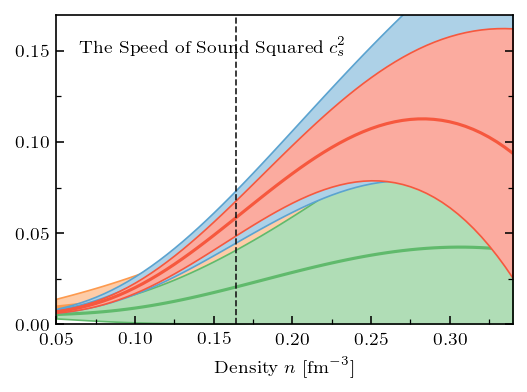

In [83]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 2.5))

speed_of_sounds = []
speed_of_sound_stds = []
for i, n in enumerate(orders):
    E_per_N_samples_n = obs_neutron.draw_sample(order=n, num_samp=500)
    speed_of_sound_samples = compute_speed_of_sound(
        obs_neutron.density_interp,
        obs_neutron.kf_interp,
        E=E_per_N_samples_n[0].T,
        dE=E_per_N_samples_n[1].T,
        d2E=E_per_N_samples_n[2].T,
        mass=mass_neutron
    )
    speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    speed_of_sounds.append(speed_of_sound_mean)
    speed_of_sound_stds.append(speed_of_sound_std)
    
#     speed_of_sound_alt_diff = compute_speed_of_sound(
#         obs_neutron.density,
#         obs_neutron.kf,
#         E=obs_neutron.finite_difference(order=n, deriv=0, wrt_kf=True),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True),
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=True),
#         mass=mass_neutron
#     )
#     speed_of_sound_alt_diff = compute_speed_of_sound(
#         obs_neutron.density,
#         obs_neutron.kf,
#         E=obs_neutron.finite_difference(order=n, deriv=0, wrt_kf=False),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=False),
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=False),
#         mass=mass_neutron,
#         wrt_kf=False,
#     )
    speed_of_sound_alt_diff = compute_speed_of_sound(
        obs_neutron.density,
        obs_neutron.kf,
        E=obs_neutron.poly_interp(order=n, deriv=0, wrt_kf=False),
        dE=obs_neutron.poly_interp(order=n, deriv=1, wrt_kf=False),
        d2E=obs_neutron.poly_interp(order=n, deriv=2, wrt_kf=False),
        mass=mass_neutron,
        wrt_kf=False,
    )
    
    plot_obs_vs_density(
        density_all,
        speed_of_sound_mean,
        speed_of_sound_std,
        ax=ax,
#         color_68=colors[i],
#         color_95=light_colors[i],
#         c=dark_colors[i],
        color_68=light_colors[i],
        c=colors[i],
        edgecolor=colors[i],
        add_nsat=i==len(orders)-1,
        zorder=i/10,
#         density_data=obs_neutron.density,
#         y_data=speed_of_sound_alt_diff,
        fillstyle='none',
        markeredgewidth=0.5,
    )
    
    
speed_of_sounds = np.array(speed_of_sounds).T
speed_of_sound_stds = np.array(speed_of_sound_stds).T
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylim(0, 0.17)
ax.tick_params(right=True, which='both')
ax.text(0.05, 0.92, s='The Speed of Sound Squared $c_s^2$', transform=ax.transAxes, ha='left', va='top');
fig.savefig(join(fig_path, f'speed_of_sound_Lambda-{Lambda}'))
# ax.set_ylabel('Speed of Sound');

/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


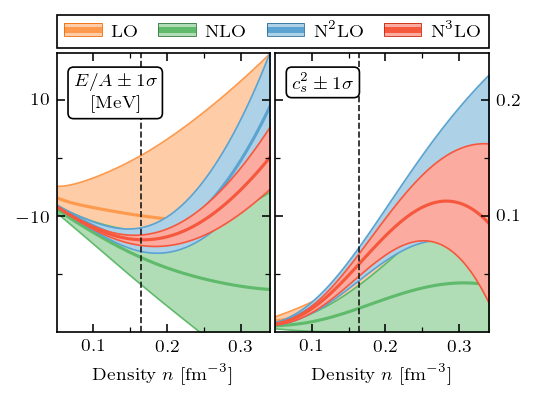

In [84]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(1, 2, sharey=False, sharex=True, figsize=(3.4, 2.5))
    for i, n in enumerate(orders):
        plot_obs_vs_density(
            density_all,
            energies_s[:, i],
            energy_s_stds[:, i],
            ax=axes[0],
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            fillstyle='none',
            markeredgewidth=0.5,
        )

        plot_obs_vs_density(
            density_all,
            speed_of_sounds[:, i],
            speed_of_sound_stds[:, i],
            ax=axes[1],
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            fillstyle='none',
            markeredgewidth=0.5,
        )


    axes[0].set_ylim(-30+1e-5, 18-1e-5)
    axes[1].set_ylim(1e-5, 0.24-1e-5)
    # axes[0].yaxis.set_major_locator(MultipleLocator(10))
#     axes[0].set_yticks([-15, -5, 5, 15])
    axes[0].set_yticks([-10, 10])
    axes[1].set_yticks([0.1, 0.2])
#     axes[1].yaxis.set_major_locator(MultipleLocator(0.05))


    label_es = r"""$E/A \pm 1\sigma$
    [MeV]"""
    label_cs = r"""$c_s^2 \pm 1\sigma$"""
    axes[0].text(
        0.08, 0.93, label_es, transform=axes[0].transAxes, ha='left', va='top',
        multialignment='center', zorder=10,
        bbox=dict(facecolor='w', boxstyle='round')
    )
    axes[1].text(
        0.08, 0.93, label_cs, transform=axes[1].transAxes, ha='left', va='top',
        multialignment='center', zorder=10,
        bbox=dict(facecolor='w', boxstyle='round')
    )
    axes[1].yaxis.tick_right()
    for ax in axes.ravel():
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(left=True, right=True, bottom=True, top=True, which='both')

    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.1/72)
    add_top_order_legend(fig, axes[0], axes[1], order_labels, colors, light_colors, dark_colors)
    fig.savefig(join(fig_path, f'energy-obs-s_with_speed_of_sound_Lambda-{Lambda}'))
    plt.show()

In [85]:
sat_n_emp_idx = np.where(np.abs((density_all - 0.16)) < 1e-10)[0][0]
sat_n_ham_idx = np.where(np.abs((density_all - 0.17)) < 1e-10)[0][0]

In [86]:
sat_n_emp_idx

22

In [87]:
print(f'n = {density_all[sat_n_emp_idx]:0.2f}')
print(f'P = {pressures_s[sat_n_emp_idx, -1]} +/- {pressure_s_stds[sat_n_emp_idx, -1]:0.2f}')
print(f'K = {K_incomps[sat_n_emp_idx, -1]} +/- {K_incomp_stds[sat_n_emp_idx, -1]:0.0f}')

n = 0.16
P = -0.1921095034394925 +/- 0.35
K = 223.74411324196825 +/- 37


In [88]:
print(f'n = {density_all[sat_n_ham_idx]:0.2f}')
print(f'P = {pressures_s[sat_n_ham_idx, -1]} +/- {pressure_s_stds[sat_n_ham_idx, -1]:0.2f}')
print(f'K = {K_incomps[sat_n_ham_idx, -1]} +/- {K_incomp_stds[sat_n_ham_idx, -1]:0.0f}')

n = 0.17
P = 0.06652214729486942 +/- 0.43
K = 257.256031234424 +/- 44


In [89]:
print(f'n = {density_all[-1]:0.2f}')
print(f'N2LO cs^2 = {speed_of_sounds[-1, -2]} +/- {speed_of_sound_stds[-1, -2]:0.2f}')
print(f'N3LO cs^2 = {speed_of_sounds[-1, -1]} +/- {speed_of_sound_stds[-1, -1]:0.2f}')

n = 0.34
N2LO cs^2 = 0.1389579803403615 +/- 0.08
N3LO cs^2 = 0.09394398211050481 +/- 0.07


In [90]:
# from matplotlib import legend_handler
# from matplotlib.legend_handler import HandlerLine2D

# class OrderBandsHandler:
    
# #     def __init__(self, edgecolor, facecolor, facecolor2=None, **kwargs):
# #         if facecolor2 is None:
# #             facecolor2 = facecolor
            
# #         self.edgecolor = edgecolor
# #         self.facecolor = facecolor
# #         self.facecolor2 = facecolor2
        
#     def legend_artist(self, legend, orig_handle, fontsize, handlebox):
#         print('hello!', flush=True)
#         x0, y0 = handlebox.xdescent, handlebox.ydescent
#         width, height = handlebox.width, handlebox.height
        
#         light_rect = orig_handle[0]
#         dark_rect = orig_handle[1]
#         dark_line = orig_handle[2]
        
#         light_color = light_rect.get_facecolor()[0]
#         color = dark_rect.get_facecolor()[0]
#         dark_color = dark_line.get_color()
        
        
#         patch_outer = mpatches.Rectangle(
#             [x0, y0], width, height, facecolor=light_color,
#             edgecolor=dark_color, lw=1,
#             transform=handlebox.get_transform()
#         )
#         patch_inner = mpatches.Rectangle(
#             [x0, y0+height/4], width, height/2, facecolor=color,
#             edgecolor=dark_color, lw=0,
#             transform=handlebox.get_transform()
#         )
#         handlebox.add_artist(patch_outer)
#         handlebox.add_artist(patch_inner)
#         handlebox.add_artist(dark_line)
#         return patch_outer, patch_inner, dark_line
    
    


In [91]:
obs_sym_energy.density

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26,
       0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34])

In [92]:
# obs_sym_energy.density[data_slice]

/Users/furnstah/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


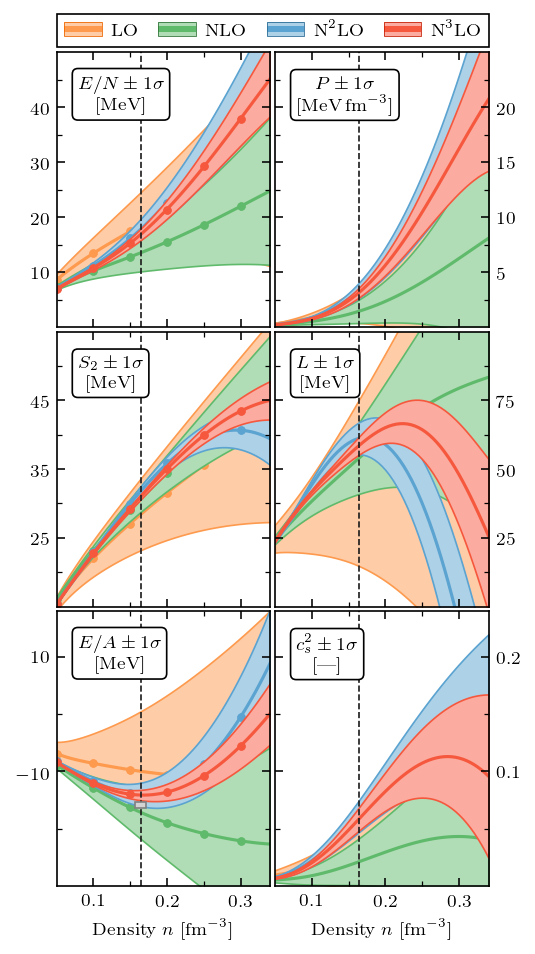

In [93]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    # fig, axes = plt.subplots(1, 3, sharey=False, sharex=True, figsize=(7, 3))
    # ax_EN = axes[0]
    # ax_S2 = axes[1]
    # ax_cs = axes[2]

    text_kwargs = dict(
        x=0.1, y=0.92, ha='left', va='top',
        multialignment='center',
        bbox=dict(boxstyle='round', facecolor='w'),
        zorder=10
    )
    
    data_slice = slice(None, None, 5)
    panels_include_trunc = True
    
    make_3x2 = True
    make_2x3 = False

    if make_3x2:
        fig, axes = plt.subplots(3, 2, sharey=False, sharex='col', figsize=(3.4, 6.2), constrained_layout=True)
    elif make_2x3:
        fig, axes = plt.subplots(2, 3, sharey=False, sharex='col', figsize=(7, 6), constrained_layout=True)
    else:
        fig, axes = plt.subplots(2, 2, sharey=False, sharex='col', figsize=(3.4, 4), constrained_layout=True)
        
    if make_3x2:
        ax_EN = axes[0, 0]
        ax_S2 = axes[1, 0]
        ax_P = axes[0, 1]
        ax_L = axes[1, 1]
        ax_EA = axes[2, 0]
        ax_cs = axes[2, 1]
    elif make_2x3:
        ax_EN = axes[0, 0]
        ax_S2 = axes[0, 2]
        ax_P = axes[1, 0]
        ax_L = axes[1, 2]
        ax_EA = axes[0, 1]
        ax_cs = axes[1, 1]
    else:
        ax_EN = axes[0, 0]
        ax_S2 = axes[1, 0]
        ax_P = axes[0, 1]
        ax_L = axes[1, 1]
    
    ms_4x4 = 3


    for i, n in enumerate(orders):
        plot_obs_vs_density(
            density_all,
            obs_neutron.get_pred(order=n, deriv=0),
            obs_neutron.get_std(order=n, deriv=0, include_trunc=panels_include_trunc),
#             color_68=colors[i],
#             color_95=light_colors[i],
#             c=dark_colors[i],
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            ax=ax_EN,
            density_data=obs_neutron.density[data_slice],
            y_data=obs_neutron.finite_difference(order=n, deriv=0)[data_slice],
            markersize=ms_4x4,
        )
    EN_text = r'$E/N$ [MeV]'
    EN_text = R"""$E/N\pm 1\sigma$
    [MeV]"""
    ax_EN.text(s=EN_text, transform=ax_EN.transAxes, **text_kwargs)
#     ax_EN.set_ylim(1e-5, 40-1e-5)
    ax_EN.set_ylim(1e-5, 50-1e-5)


    for i, n in enumerate(orders):
        plot_obs_vs_density(
            density_all,
            obs_sym_energy.get_pred(order=n, deriv=0),
            obs_sym_energy.get_std(order=n, deriv=0, include_trunc=panels_include_trunc),
#             color_68=colors[i],
#             color_95=light_colors[i],
#             c=dark_colors[i],
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            ax=ax_S2,
            density_data=obs_sym_energy.density[data_slice],
            y_data=obs_sym_energy.finite_difference(order=n, deriv=0)[data_slice],
            markersize=ms_4x4,
        )
    # ax_S2.set_title(r'$S_2$ [MeV]');
    S2_text = R"""$S_2 \pm 1\sigma$
    [MeV]"""
    ax_S2.text(s=S2_text, transform=ax_S2.transAxes, **text_kwargs)
#     ax_S2.yaxis.set_major_locator(MultipleLocator(10))
#     ax_S2.set_ylim(10+1e-5, 50-1e-4)
    ax_S2.set_yticks([25, 35, 45])
    ax_S2.set_ylim(15+1e-5, 55-1e-4)


    # for i, n in enumerate(orders):
    #     E_per_N_samples_n = obs_neutron.draw_sample(order=n, num_samp=500)
    #     speed_of_sound_samples = compute_speed_of_sound(
    #         obs_neutron.density_interp,
    #         obs_neutron.kf_interp,
    #         E=E_per_N_samples_n[0].T,
    #         dE=E_per_N_samples_n[1].T,
    #         d2E=E_per_N_samples_n[2].T,
    #         mass=mass_neutron
    #     )
    #     speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    #     speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    #     plot_obs_vs_density(
    #         density_all,
    #         speed_of_sound_mean,
    #         speed_of_sound_std,
    #         color_68=colors[i],
    #         color_95=light_colors[i],
    #         c=dark_colors[i],
    #         add_nsat=i==0,
    #         zorder=i/10,
    #         ax=ax_cs
    #     )
    # # axes[2].set_title('Speed of Sound');
    # ax_cs.text(0.05, 0.95, r'$c_s^2$', transform=ax_cs.transAxes, ha='left', va='top')
    # ax_cs.set_ylim(0, None)
    # ax_cs.yaxis.set_major_locator(MultipleLocator(0.05))
    # ax_cs.yaxis.set_minor_locator(AutoMinorLocator(2))



    for i, n in enumerate(orders):
        pressure_n = compute_pressure(
            obs_neutron.density_interp,
            obs_neutron.kf_interp,
            dE=obs_neutron.get_pred(order=n, deriv=1)
        )
        pressure_n_cov = compute_pressure_cov(
            obs_neutron.density_interp,
            obs_neutron.kf_interp,
            dE_cov=obs_neutron.get_cov(order=n, deriv1=1, deriv2=1, include_trunc=panels_include_trunc)
        )
        pressure_n_std = np.sqrt(np.diag(pressure_n_cov))
        
#         pressure_alt_diff_n = compute_pressure(
#             obs_neutron.density,
#             obs_neutron.kf,
#             dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True)
#         )
        pressure_alt_diff_n = compute_pressure(
            obs_neutron.density,
            obs_neutron.kf,
            dE=obs_neutron.poly_interp(order=n, deriv=1, wrt_kf=False),
            wrt_kf=False
        )
        
        plot_obs_vs_density(
            density_all,
            pressure_n,
            pressure_n_std,
#             color_68=colors[i],
#             color_95=light_colors[i],
#             c=dark_colors[i],
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            ax=ax_P,
#             density_data=obs_neutron.density[data_slice],
#             y_data=pressure_alt_diff_n[data_slice],
            markersize=ms_4x4,
            fillstyle='none',
            markeredgewidth=0.5,
        )
    # ax_P.axhline(0, 0, 1, c='k', lw=0.4, zorder=1)
    # ax_P.set_title('Symmetric Nuclear Matter')
    # ax_P.set_ylabel('Pressure $P$ [MeV\,fm$^{-3}$]');
    P_text = r'$P$ [MeV\,fm$^{-3}$]'
    P_text = R"""$P\pm 1\sigma$
    [MeV\,fm$^{-3}$]"""
    ax_P.text(s=P_text, transform=ax_P.transAxes, **text_kwargs)
#     ax_P.set_ylim(0+1e-5, 8-1e-5)
    ax_P.set_ylim(0+1e-5, 25-1e-5)




    for i, n in enumerate(orders):
        slope = compute_slope(
            obs_sym_energy.density_interp,
            obs_sym_energy.kf_interp,
            dS2=obs_sym_energy.get_pred(order=n, deriv=1),
            wrt_kf=False
        )
        slope_cov = compute_slope_cov(
            obs_sym_energy.density_interp,
            obs_sym_energy.kf_interp,
            dS2_cov=obs_sym_energy.get_cov(
                order=n, deriv1=1, deriv2=1, include_trunc=panels_include_trunc),
            wrt_kf=False
        )
        slope_std = np.sqrt(np.diag(slope_cov))
        
#         slope_alt_diff = compute_slope(
#             obs_sym_energy.density,
#             obs_sym_energy.kf,
#             dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=True)
#         )
        slope_alt_diff = compute_slope(
            obs_sym_energy.density,
            obs_sym_energy.kf,
            dS2=obs_sym_energy.poly_interp(order=n, deriv=1, wrt_kf=False),
            wrt_kf=False,
        )
        
        plot_obs_vs_density(
            density_all,
            slope,
            slope_std,
#             color_68=colors[i],
#             color_95=light_colors[i],
#             c=dark_colors[i],
            color_68=light_colors[i],
            c=colors[i],
            edgecolor=colors[i],
            add_nsat=i==len(orders)-1,
            zorder=i/10,
            ax=ax_L,
#             density_data=obs_sym_energy.density[data_slice],
#             y_data=slope_alt_diff[data_slice],
            markersize=ms_4x4,
            fillstyle='none',
            markeredgewidth=0.5,
        )
    # ax_L.set_ylabel('Slope $L$ [MeV]');
    L_text = r'$L$ [MeV]'
    L_text = R"""$L\pm 1\sigma$
    [MeV]"""
    ax_L.text(s=L_text, transform=ax_L.transAxes, **text_kwargs)
    ax_L.yaxis.set_major_locator(MultipleLocator(25))
    ax_L.set_ylim(0+1e-5, 100-1e-4)
    
    
    
    if make_3x2 or make_2x3:
        for i, n in enumerate(orders):
            plot_obs_vs_density(
                density_all,
                obs_nuclear.get_pred(order=n, deriv=0),
                obs_nuclear.get_std(order=n, deriv=0, include_trunc=panels_include_trunc),
                ax=ax_EA,
                color_68=light_colors[i],
                c=colors[i],
                edgecolor=colors[i],
                add_nsat=i==len(orders)-1,
                zorder=i/10,
                markersize=ms_4x4,
                density_data=obs_nuclear.density[data_slice],
                y_data=obs_nuclear.finite_difference(order=n, deriv=0)[data_slice],
            )
            
            E_per_N_samples_n = obs_neutron.draw_sample(
                order=n, num_samp=1007, include_trunc=panels_include_trunc)
            speed_of_sound_samples = compute_speed_of_sound(
                obs_neutron.density_interp,
                obs_neutron.kf_interp,
                E=E_per_N_samples_n[0].T,
                dE=E_per_N_samples_n[1].T,
                d2E=E_per_N_samples_n[2].T,
                mass=mass_neutron
            )
            speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
            speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)

            plot_obs_vs_density(
                density_all,
                speed_of_sound_mean,
                speed_of_sound_std,
                ax=ax_cs,
                color_68=light_colors[i],
                c=colors[i],
                edgecolor=colors[i],
                add_nsat=i==len(orders)-1,
                zorder=i/10,
                fillstyle='none',
                markeredgewidth=0.5,
            )


#         ax_EA.set_ylim(-25+1e-5, 10-1e-5)
#         ax_EA.set_yticks([-15, -5, 5])
#         ax_cs.yaxis.set_major_locator(MultipleLocator(0.05))
#         ax_cs.set_ylim(1e-5, 0.175-1e-5)
        ax_EA.set_ylim(-30+1e-5, 18-1e-5)
        ax_cs.set_ylim(1e-5, 0.24-1e-5)
        ax_EA.set_yticks([-10, 10])
        ax_cs.set_yticks([0.1, 0.2])
        
        plot_empirical_saturation(ax_EA, alpha=1)
        
        
        label_es = r"""$E/A \pm 1\sigma$
        [MeV]"""
        label_cs = r"""$c_s^2 \pm 1\sigma$
        [---]"""
        ax_EA.text(
            s=label_es, transform=ax_EA.transAxes, **text_kwargs
        )
        ax_cs.text(
            s=label_cs, transform=ax_cs.transAxes, **text_kwargs
        )
#         axes[1].yaxis.tick_right()
#         for ax in axes.ravel():
#             ax.yaxis.set_minor_locator(AutoMinorLocator(2))
#             ax.xaxis.set_major_locator(MultipleLocator(0.1))
#             ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#             ax.tick_params(left=True, right=True, bottom=True, top=True, which='both')


    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i, j]
            if j == 1:
                ax.yaxis.tick_right()
                ax.set_xticks(axes[0, 0].get_xticks()[2:-1])
    #             ax.xaxis.set_major_locator(MaxNLocator(nbins=3, steps=[0.05, 0.1, 0.15, 0.2], prune='lower'))
            if i < axes.shape[0] - 1:
                ax.set_xlabel('')
            ax.tick_params(left=True, bottom=True, right=True, top=True, which='both')
            ax.yaxis.set_minor_locator(AutoMinorLocator(2))
            ax.xaxis.set_major_locator(MultipleLocator(0.1))


#     fig.set_constrained_layout_pads(h_pad=1.3/72, w_pad=0.5/72)
#     fig.canvas.draw()  # Must draw to get positions right before getting locations
#     # Get the corner of the upper right plot in display coordinates
#     upper_right_display = axes[0, 1].transAxes.transform((1, 1))
#     # Now put it in axes[0,0] coords
#     upper_right_axes00 = axes[0, 0].transAxes.inverted().transform(upper_right_display)
#     handlers_ords = compute_filled_handles(colors, light_colors, dark_colors)
#     # Must use axes[0,0] legend for constrained layout to work with it
#     leg = axes[0,0].legend(
#         handlers_ords, order_labels, ncol=4,
#         loc='lower left', bbox_to_anchor=(0, 1.02, upper_right_axes00[0], 1.),
#         mode='expand',
#         columnspacing=0,
#         handletextpad=0.5,
#         fancybox=False, borderaxespad=0,
#         handler_map={tuple: OrderBandsHandler()}
#     )
    fig.set_constrained_layout_pads(h_pad=1.1/72, w_pad=1.1/72)
    add_top_order_legend(fig, axes[0,  0], axes[0, 1], order_labels, colors, light_colors, dark_colors)
    fig.savefig(join(fig_path, f'energies_and_related_derivatives_Lambda-{Lambda}_trunc-{panels_include_trunc}'))
    plt.show()

In [94]:
speed_of_sound_stds[-1, -1]*2

0.13690359605629787

In [95]:
speed_of_sounds[-1, -1] + speed_of_sound_stds[-1, -1]*2

0.23084757816680268

In [96]:
speed_of_sounds[-1, -1] - speed_of_sound_stds[-1, -1]*2

-0.04295961394579306

In [97]:
speed_of_sound_stds.shape

(59, 4)

In [98]:
speed_of_sound_stds[-1, -2]*2

0.16504154274332394

In [99]:
speed_of_sound_stds[-1, -2]

0.08252077137166197

In [100]:
speed_of_sounds[-1, -2]

0.1389579803403615

In [101]:
speed_of_sounds[-1, -2] + speed_of_sound_stds[-1, -1]*2

0.27586157639665937

In [102]:
speed_of_sounds[-1, -2] - speed_of_sound_stds[-1, -1]*2

0.002054384284063626